# Learning to create a basic RL environment using Gymnasium

In [1]:
import gymnasium as gym
import numpy as np
import os
import matplotlib.pyplot as plt

os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

## Understanding the Cartpole environment implementation

The library Gymnasium have some classic environments implemented (Cartopole example included). You can check the Cartpole implementation [here](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py). You can create a cartpole environment using the following:

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

The agent actions are "left" or "right", and the environment considers a discrete variable 0 and 1 representing them. Try re-running the code below to verify the `action_space.sample()` function generating different possible actions to be applied in the environment. The action space is a placeholder that indicates the format an action should follow.

In [3]:
print(f"Action space: {env.action_space}")
print(f"1st sample of action space: {env.action_space.sample()}")
print(f"2nd sample of action space: {env.action_space.sample()}")
print(f"3rd sample of action space: {env.action_space.sample()}")

Action space: Discrete(2)
1st sample of action space: 0
2nd sample of action space: 1
3rd sample of action space: 0


The action space using Gym can also verify if a given variable obbeys to the pre-defined action space format to avoid incompatibility problems.

In [4]:
action1 = 0
action2 = 3
action3 = "left"
action4 = [0]
env.action_space.contains(0)
print(f"Action 1 is valid: {env.action_space.contains(action1)}")
print(f"Action 2 is valid: {env.action_space.contains(action2)}")
print(f"Action 3 is valid: {env.action_space.contains(action3)}")
print(f"Action 4 is valid: {env.action_space.contains(action4)}")

Action 1 is valid: True
Action 2 is valid: False
Action 3 is valid: False
Action 4 is valid: False


In the same way, the observartion space to the cartpole is defined as 4 variables ([here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)) representing:

![Cartpole observation](imgs/cartpole_obs.png)

The Gymnasium environment already implement an observation space placeholder with that information as we can check using:

In [5]:
print("Observation space type and format: ", env.observation_space)
print("1st sample of observation space: ", env.observation_space.sample())
print("2nd sample of observation space: ", env.observation_space.sample())
print("3rd sample of observation space: ", env.observation_space.sample())

Observation space type and format:  Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
1st sample of observation space:  [-2.4483168  -0.49678594 -0.15621512 -0.01197281]
2nd sample of observation space:  [1.6944023 1.2184525 0.3165944 2.758321 ]
3rd sample of observation space:  [-3.7305336  -0.66345435  0.1900697  -0.24549282]


The different Spaces, like Box and Discrete, available in Gymnasium could be checked [here](https://gymnasium.farama.org/api/spaces/).

**The reward function does not need a placeholder specification like the action and observation space since it is always a unique real number.**

## Modeling the dumbest agent possible for controlling the cartpole problem (**Without RL**)

Remember, the agent needs to utilize the observation to generate an action that complies with the action space format. Therefore, for the cartpole the action must be a discrete number between 0 and 1.

In [6]:
def dumb_action_policy(observation: np.ndarray) -> int:
    pole_angle = observation[2]
    return 0 if pole_angle < 0 else 1

### Integrating the agent and the environment

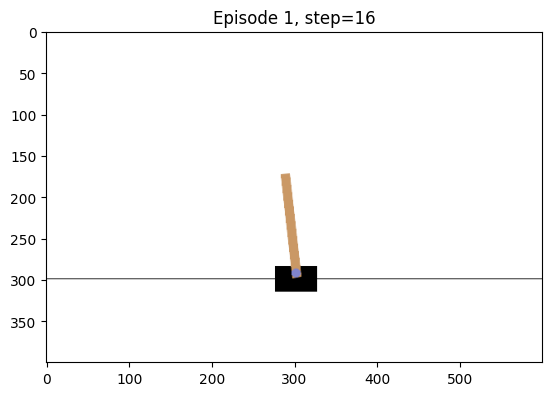

In [ ]:
number_of_episodes = 10

terminated = False
total_reward = 0
report_performance = []
for episode in range(number_of_episodes):
    obs, _ = env.reset()  # Initial observation
    terminated = False  # True when an episode has finished
    total_reward = 0
    number_steps_not_falling = 0
    while not terminated:
        action = dumb_action_policy(obs)  # Take action from agent
        obs, reward, terminated, truncated, info = env.step(
            action
        )  # Applying the action in the environment
        total_reward += float(reward)
        number_steps_not_falling += 1

        # Code to show the animation
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.title(f"Episode {episode + 1}, step={number_steps_not_falling}")
        plt.show()
        # End - Code to show the animation
    report_performance.append((total_reward, number_steps_not_falling))
print("Performance report:")
for episode, (total_reward, number_steps_not_falling) in enumerate(report_performance):
    print(
        f"Episode {episode + 1}: reward={total_reward}, steps={number_steps_not_falling}"
    )

## What is needed to implement a custom environment using the Gymnasium API?

Gymnasium has a documentation explaining the details of an environment definition [here](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#). Here, we will create a (super) simple example based on a guess the number game. First, let's remember what is an environment and its interactions with the agent looking at the [Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html) figure below.

![RL agent and environment](./imgs/rl_concept.png)

The environment must have a function that receives an action from the agent and applies it in the environment, generating a reward and a new state that will be returned to the agent. The Gymnasium API requires the custom environment to contain the following functions:
  - `step()`: A function that receives an action from the agent and returns an observation and reward.
  - `reset()`: A function that returns the environment for an initial state.
  - (optional) `render()`: A function that renders images from the environment.
  - (optional) `close()`: A function that closes the rendering of the environment.

So, let's create our (super) guess the number environment.

In [ ]:
class GuessNumber(gym.Env):
    def __init__(self):
        self.number = np.random.randint(100)  # Number to be guessed (0 to 99)
        self.action_space = gym.spaces.Discrete(100)  # 0 to 99
        self.observation_space = gym.spaces.MultiDiscrete(
            [1, 1]
        )  # first variable represents -1: starting game, 0: too low, 1: correct, 2: too high. Last variable is the previous action

    def reset(self):
        # When the environment is reset, a new number is generated (starting a new episode)
        self.number = np.random.randint(100)
        observation = [-1, -1]
        self.steps_without_winning = 0
        info = {"text": "New episode started"}
        return observation, info

    def step(self, action):
        terminated = False
        truncated = False
        if action < self.number:
            observation = [0, action]
            reward = -1
            info = {"text": f"The guessed number {action} is too low"}
        elif action > self.number:
            observation = [2, action]
            reward = -1
            info = {"text": f"The guessed number {action} is too high"}
        else:
            observation = [1, action]
            reward = 0
            terminated = True
            info = {"text": "Congratulations! You guessed the number"}

        return observation, reward, terminated, truncated, info

### Creating the dumbest agent ever made to play our guess the number game

In [ ]:
def guess_the_number_agent(observation):
    tip = observation[0]
    previous_action = observation[1]
    if tip == -1:
        return np.random.randint(100)  # Starting the game: select a random number
    elif tip == 0:
        return np.random.randint(
            previous_action, 100
        )  # Select a random number smaller than the previous one
    elif tip == 2:
        return np.random.randint(
            0, previous_action
        )  # Select a random number bigger than the previous one
    else:
        return previous_action  # We won! Keep the number

### Using our dumb agent in the guess the number environment

In [ ]:
env = GuessNumber()
number_of_episodes = 10

terminated = False
total_reward = 0
report_performance = []
steps = 0
for episode in range(number_of_episodes):
    obs, _ = env.reset()  # Initial observation
    terminated = False  # True when an episode has finished
    total_reward = 0
    while not terminated:
        action = guess_the_number_agent(obs)  # Take action from agent
        obs, reward, terminated, truncated, info = env.step(
            action
        )  # Applying the action in the environment
        total_reward += float(reward)
        right_action = action
    report_performance.append((total_reward, right_action))
print("Performance report:")
for episode, (total_reward, right_action) in enumerate(report_performance):
    print(f"Episode {episode + 1}: reward={total_reward}, right number: {right_action}")

Performance report:
Episode 1: reward=-129.0, right number: 67
Episode 2: reward=-69.0, right number: 69
Episode 3: reward=-153.0, right number: 11
Episode 4: reward=-27.0, right number: 42
Episode 5: reward=-4.0, right number: 0
Episode 6: reward=-20.0, right number: 30
Episode 7: reward=-122.0, right number: 58
Episode 8: reward=-34.0, right number: 40
Episode 9: reward=-14.0, right number: 51
Episode 10: reward=-60.0, right number: 35
